In [62]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [63]:
df = pd.read_csv("../data/processed/financial_fraud_data.csv")

In [64]:
df.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,CASH_IN,330218.42,20866.00,351084.42,452419.57,122201.15,0
1,PAYMENT,11647.08,30370.00,18722.92,0.00,0.00,0
2,CASH_IN,152264.21,106589.00,258853.21,201303.01,49038.80,0
3,TRANSFER,1551760.63,0.00,0.00,3198359.45,4750120.08,0
4,CASH_IN,78172.30,2921331.58,2999503.88,415821.90,337649.60,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            50000 non-null  object 
 1   amount          50000 non-null  float64
 2   oldbalanceOrg   50000 non-null  float64
 3   newbalanceOrig  50000 non-null  float64
 4   oldbalanceDest  50000 non-null  float64
 5   newbalanceDest  50000 non-null  float64
 6   isFraud         50000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.7+ MB


Before we train and test our model. Lets identify categorical objects in our data that could be used to convert into numeric identifiers so we could train our model. 

The broad term for converting categorical variable into numerical representation is called categorical encoding or feature encoding. The two most popular method for accomplishing this is through 1. Label Encoding or 2. One-Hot Encoding (Dummy Encoding).

Label Encoding introduces ordinal relationships between categories. This means that certain categories may be given more importance over others based on their numbering. In our data we would want to avoid that. If it was in the case where the category has an order of importance over other like education degree then it may be more appropriate to use label encoding. 

Code for label encoding below.

In [44]:
# We are making a list of categorical columns where unique samples are less than 50. 

#categorical_columns = []
#for column in df.columns:
    #if df[column].dtype == object and len(df[column].unique()) <= 50:
        #categorical_columns.append(column)

In [45]:
# We only appended the "type" column in this case because its the only column which type is "object" and the number of unique values is less than 50.
 
#categorical_columns

In [46]:
# Next we want to use label encoders to help us transform categorical values into numerical labels.

#label = LabelEncoder()
#for column in categorical_columns:
    #df[column] = label.fit_transform(df[column])

Lets use One Hot Encoding (Dummy Encoding) for now

In [66]:
df_encoded = pd.get_dummies(df, columns = ["type"], prefix=["Category"])
df_encoded = df_encoded.astype(int)

In [67]:
df_encoded.head(10)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Category_CASH_IN,Category_CASH_OUT,Category_DEBIT,Category_PAYMENT,Category_TRANSFER
0,330218,20866,351084,452419,122201,0,1,0,0,0,0
1,11647,30370,18722,0,0,0,0,0,0,1,0
2,152264,106589,258853,201303,49038,0,1,0,0,0,0
3,1551760,0,0,3198359,4750120,0,0,0,0,0,1
4,78172,2921331,2999503,415821,337649,0,1,0,0,0,0
5,915,0,0,0,0,0,0,0,0,1,0
6,20603,0,0,558068,578672,0,0,1,0,0,0
7,58605,0,0,585494,644100,0,0,1,0,0,0
8,4865,0,0,0,0,0,0,0,0,1,0
9,118131,0,0,8131691,8476246,0,0,1,0,0,0


In [60]:
# We might not need to drop a column when doing One Hot Encoding, since the model we will be using decision tree, random forest can handle multicollinearity to some extent.

In [70]:
# Now lets create a "X" and "y" training set. We want to define our feature Matrix and our Target variable
# Then we will use the train test split on our newly created X and y variable

X = df_encoded.drop("isFraud", axis=1)
y = df_encoded["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [71]:
# Lets use the "print score" method to generate a report for us

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [72]:
# Now we are ready to create our simple DecisionTreeClassifier object.

tree_clf = DecisionTreeClassifier(random_state=42)

#Lets fit it on our newly created "X" and "y" dataset. 

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [74]:
# We will generate two reports. One for X_train which would be when train = True and one for X_test for when train = False

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0     1  accuracy  macro avg  weighted avg
precision      1.0   1.0       1.0        1.0           1.0
recall         1.0   1.0       1.0        1.0           1.0
f1-score       1.0   1.0       1.0        1.0           1.0
support    34955.0  45.0       1.0    35000.0       35000.0
_______________________________________________
Confusion Matrix: 
 [[34955     0]
 [    0    45]]

Test Result:
Accuracy Score: 99.94%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.999533   0.90    0.9994      0.949766      0.999367
recall         0.999866   0.72    0.9994      0.859933      0.999400
f1-score       0.999700   0.80    0.9994      0.899850      0.999367
support    14975.000000  25.00    0.9994  15000.000000  15000.000000
_______________________________________

In [76]:
# Now lets find the best possible hyperparameters, using GridSearchCV and print our results.

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best paramters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 99.96%
_______________________________________________
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999657   0.942857    0.9996      0.971257      0.999584
recall         0.999943   0.733333    0.9996      0.866638      0.999600
f1-score       0.999800   0.825000    0.9996      0.912400      0.999575
support    34955.000000  45.000000    0.9996  35000.000000  35000.000000
_______________________________________________
Confusion Matrix: 
 [[34953     2]
 [   12    33]]

Test Result:
Accuracy Score: 99.93%
_______________________________________________
CLASSIFICATION REPORT:
                      0      1  accuracy     macro avg  weighted avg
precision      0.999333   1.00  0.999333      0.999666      0.9

In [77]:
# Now lets create a 'RandomForestClassifier' with 100 trees and fit our random forest with our X and Y trained data.

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [78]:
# Print a report of how well our model performed.

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0     1  accuracy  macro avg  weighted avg
precision      1.0   1.0       1.0        1.0           1.0
recall         1.0   1.0       1.0        1.0           1.0
f1-score       1.0   1.0       1.0        1.0           1.0
support    34955.0  45.0       1.0    35000.0       35000.0
_______________________________________________
Confusion Matrix: 
 [[34955     0]
 [    0    45]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999533   1.000000  0.999533      0.999766      0.999534
recall         1.000000   0.720000  0.999533      0.860000      0.999533
f1-score       0.999766   0.837209  0.999533      0.918488      0.999495
support    14975.000000  25.000000  0.999533  15000.000000  15000.000000
___________________

In [79]:
# From our RandomForest model we will be searching for the best hyperparameters using RandomSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='f1',
    param_distributions=random_grid, 
    n_iter=200, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/jacob/anaconda3/envs/phase1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
265 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jacob/anaconda3/envs/phase1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacob/anaconda3/envs/phase1/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jacob/anaconda3/envs/phase1/lib/python3.9/site-packages/sklearn/base.py", line 637, in _validate_params
   

Best paramters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False})


In [80]:
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.97%
_______________________________________________
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999714   1.000000  0.999714      0.999857      0.999714
recall         1.000000   0.777778  0.999714      0.888889      0.999714
f1-score       0.999857   0.875000  0.999714      0.937428      0.999696
support    34955.000000  45.000000  0.999714  35000.000000  35000.000000
_______________________________________________
Confusion Matrix: 
 [[34955     0]
 [   10    35]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999466   1.000000  0.999467      0.999733      0.999467
recall         1.000000   0.680000  0.999467      0.840000      0.999467
f1-score       0.999733   0.809524  0.999467      0.904628      0.999416
support    14975.000000  25.

Accuracy: 0.9994666666666666
Best parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


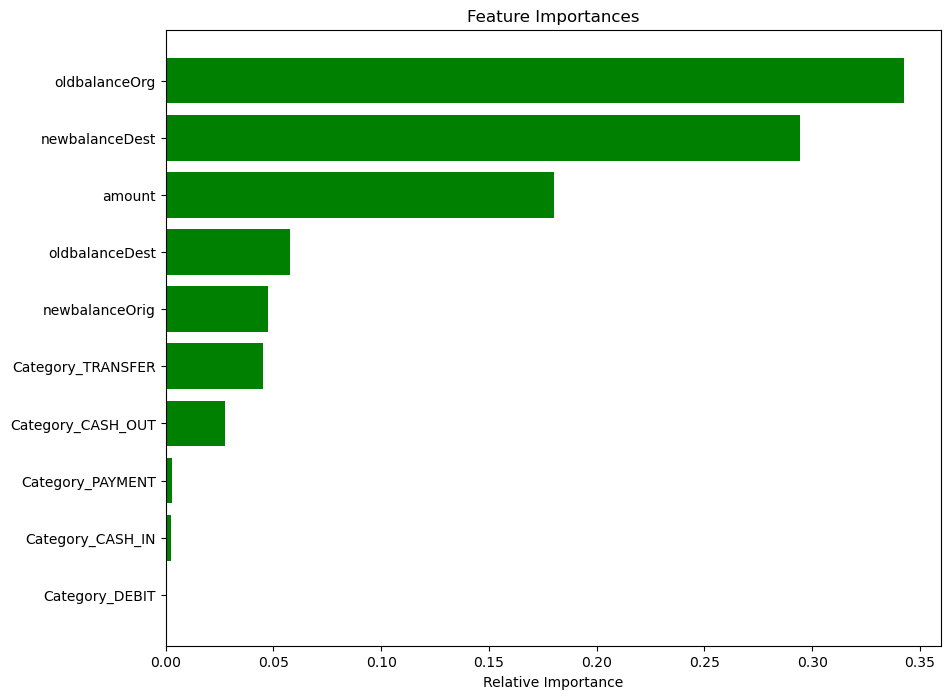

In [81]:
# Predict on the test set using the best model
best_model = rf_cv.best_estimator_
y_pred = best_model.predict(X_test)

# Print accuracy and best parameters
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Best parameters:", rf_cv.best_params_)

# Visualize feature importances
features = X.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()